In [1]:
import numpy as np
import sys
sys.path.append('/kaggle/input/sportstransformer-utils')
import prep_data
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import process_datasets
import models
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path
import shutil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import accuracy_score, f1_score
from torch import Tensor
import torch
from torch.utils.data import DataLoader
from process_datasets import load_datasets
from torch import Tensor, nn
from torch.optim import AdamW
from pytorch_lightning import LightningModule
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
import pandas as pd

plays_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2025/plays.csv')

# Get value counts of offenseFormation
formation_counts = (plays_df['offenseFormation']
    .value_counts()
    .sort_index()  
    .to_frame()  
)
print(formation_counts)

# Number of unique formations
output_dim = plays_df['offenseFormation'].nunique()

                  count
offenseFormation       
EMPTY              1342
I_FORM             1035
JUMBO               125
PISTOL              641
SHOTGUN            8791
SINGLEBACK         3915
WILDCAT              87


In [4]:
prep_data.main()
process_datasets.main()

Load players
Load plays
Load tracking
tracking_df rows: 6795800
Add features to tracking
Convert tracking to cartesian
Standardize play direction
Augment data by mirroring
Generate target - offenseFormation
Split train/test/val
Total set: 3848 plays, 614734 frames
Train set: 2694 plays, 424714 frames
Test set: 576 plays, 94456 frames
Validation set: 578 plays, 95564 frames
Creating dataset for model_type='transformer', split='test'...


Pre-computing feature transforms: 100%|██████████| 94456/94456 [02:24<00:00, 654.70it/s] 


Took 3.2 mins
Creating dataset for model_type='transformer', split='val'...


Pre-computing feature transforms: 100%|██████████| 95564/95564 [02:21<00:00, 674.74it/s] 


Took 3.2 mins
Creating dataset for model_type='transformer', split='train'...


Pre-computing feature transforms: 100%|██████████| 424714/424714 [11:39<00:00, 606.85it/s] 


Took 15.4 mins


In [5]:
# Load preprocessed datasets
train_dataset = load_datasets(model_type='transformer', split='train')
val_dataset = load_datasets(model_type='transformer', split='val')
test_dataset = load_datasets(model_type='transformer', split='test')

# Create DataLoader objects
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=3)

# Print feature and target shapes from DataLoaders
for batch in train_loader:
    features, targets = batch
    print("Train features shape:", features.shape)
    print("Train targets shape:", targets.shape)
    break

Train features shape: torch.Size([64, 22, 5])
Train targets shape: torch.Size([64, 7])


In [6]:
from models import SportsTransformerLitModel

# Model parameters
feature_len = 5  
model_dim = 64  
num_layers = 4  
dropout = 0.01
learning_rate = 1e-3
batch_size = 64
output_dim = plays_df['offenseFormation'].nunique()

model = SportsTransformerLitModel(
    feature_len=feature_len,
    batch_size=batch_size,
    model_dim=model_dim,
    num_layers=num_layers,
    output_dim=output_dim,
    dropout=dropout,
    learning_rate=learning_rate,
)

In [7]:
checkpoint_callback = ModelCheckpoint(
   dirpath=Path("checkpoints/"),
   filename="best-checkpoint",
   save_top_k=1,
   verbose=True,
   monitor="val_loss",
   mode="min",
)

early_stop_callback = EarlyStopping(
   monitor="val_loss",
   min_delta=0.001,  
   patience=5,     
   verbose=True,
   mode="min"
)


trainer = Trainer(
   max_epochs=20,  
   accelerator="gpu",  
   devices=1,
   callbacks=[checkpoint_callback, early_stop_callback],
)

In [8]:
trainer.fit(model, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [9]:
checkpoint_callback = ModelCheckpoint(
   dirpath=Path("/kaggle/working/checkpoints/"),  
   filename="best-checkpoint",
   save_top_k=1,
   verbose=True,
   monitor="val_loss",
   mode="min",
)


In [10]:
shutil.make_archive("/kaggle/working/checkpoints", 'zip', "/kaggle/working/checkpoints")

'/kaggle/working/checkpoints.zip'

In [11]:
# Inference on test data
predictions = trainer.predict(model, test_loader)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [12]:
# Concatenate predictions into a single tensor
predictions_tensor = torch.cat(predictions, dim=0)
predicted_labels = torch.argmax(predictions_tensor, dim=1)

In [13]:
# Extract true labels from the test_loader
y_true = torch.cat([y for _, y in test_loader], dim=0)

# Convert tensors to numpy arrays if needed for sklearn functions
y_true_np = np.argmax(y_true.cpu().numpy(), axis=-1)
predicted_labels_np = predicted_labels.cpu().numpy()

print("y_true shape:", y_true_np.shape)
print("Predicted labels shape:", predicted_labels_np.shape)

y_true shape: (94456,)
Predicted labels shape: (94456,)


In [14]:
df_test = pd.DataFrame({
    'gameId': [key[0] for key in test_dataset.keys],
    'playId': [key[1] for key in test_dataset.keys],
    'mirrored': [key[2] for key in test_dataset.keys],
    'frameId': [key[3] for key in test_dataset.keys],
    'true_labels': y_true_np,
    'predicted_labels': predicted_labels_np
})

In [15]:
# Attach metadata and filter to ball_snap event only
df_test_metadata = pd.read_parquet('/kaggle/working/split_prepped_data/test_features.parquet')
df_test = df_test.merge(df_test_metadata[["gameId", "playId", "mirrored", "frameId", "event", "frameType"]], on=["gameId", "playId", "mirrored", "frameId"], how="left")

# Remove frame after the snap
df_test_before_snap = df_test[df_test.frameType == "BEFORE_SNAP"]

# Filter to ball_snap event for evaluation
df_test_ball_snap = df_test[df_test.event == "ball_snap"]
df_test_ball_snap = df_test_ball_snap.drop_duplicates(subset=['gameId', 'playId', 'mirrored', 'frameId'])
df_test_ball_snap = df_test_ball_snap.sort_values(['gameId', 'playId', 'mirrored', 'frameId']).reset_index(drop=True)
display(df_test_ball_snap)

,gameId,playId,mirrored,frameId,true_labels,predicted_labels,event,frameType
0,2022090800,191,False,112,5,5,ball_snap,SNAP
1,2022090800,191,True,112,5,5,ball_snap,SNAP
2,2022090800,867,False,93,5,5,ball_snap,SNAP
3,2022090800,867,True,93,5,5,ball_snap,SNAP
4,2022090800,896,False,110,4,4,ball_snap,SNAP
...,...,...,...,...,...,...,...,...
569,2022091200,3216,True,86,5,5,ball_snap,SNAP
570,2022091200,3628,False,129,4,4,ball_snap,SNAP
571,2022091200,3628,True,129,4,4,ball_snap,SNAP
572,2022091200,3685,False,33,4,4,ball_snap,SNAP


In [16]:
true_labels = df_test_ball_snap['true_labels'].values
predicted_labels = df_test_ball_snap['predicted_labels'].values

Unique values in true labels: [0 1 2 3 4 5]
Unique values in predicted labels: [0 1 2 3 4 5]
Formation enum values: {'EMPTY': 0, 'I_FORM': 1, 'JUMBO': 2, 'PISTOL': 3, 'SHOTGUN': 4, 'SINGLEBACK': 5, 'WILDCAT': 6}
Accuracy: 0.9547
Precision (weighted): 0.9554
Recall (weighted): 0.9547
F1 Score (weighted): 0.9530


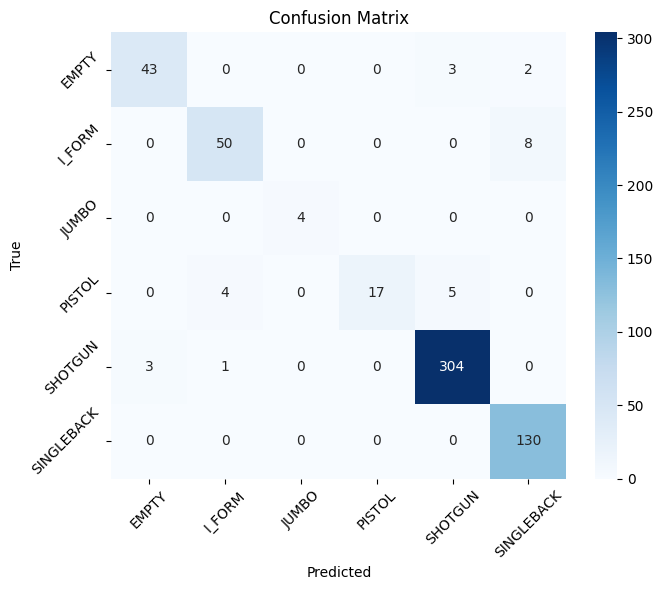

In [17]:
plt.rcParams['font.family'] = 'Times New Roman'

# Get class labels from FORMATION_ENUM and sort alphabetically
formation_labels = sorted(list(process_datasets.FORMATION_ENUM.keys()))

# Print unique values to debug
print("Unique values in true labels:", np.unique(true_labels))
print("Unique values in predicted labels:", np.unique(predicted_labels))
print("Formation enum values:", process_datasets.FORMATION_ENUM)

# Calculate metrics using labels parameter to specify valid classes
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', 
                         labels=np.unique(true_labels))
recall = recall_score(true_labels, predicted_labels, average='weighted',
                    labels=np.unique(true_labels))
f1 = f1_score(true_labels, predicted_labels, average='weighted',
             labels=np.unique(true_labels))

# Create confusion matrix only for classes that appear in the data
present_classes = sorted(list(set(np.unique(true_labels)) | set(np.unique(predicted_labels))))
conf_matrix = confusion_matrix(true_labels, predicted_labels, 
                            labels=present_classes)

# Get labels for present classes
present_labels = [formation_labels[i] for i in present_classes]

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, 
          annot=True, 
          fmt='d', 
          cmap='Blues',
          xticklabels=present_labels,
          yticklabels=present_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [19]:
FORMATION_ENUM_REV = {v: k for k, v in process_datasets.FORMATION_ENUM.items()}

fig = px.scatter(df_example_play, 
   x='x', 
   y='y',
   color='club',
   animation_frame='frameId',
   range_x=[50, 120],
   range_y=[0, 53.3],
   title='Player Positions',
   labels={'x': 'Field Length (Yards)', 'y': 'Field Width (Yards)'},
   hover_data=['nflId'],
   width=900,
   height=700,
   animation_group="nflId"
)

# Add prediction text for each frame
for frame in fig.frames:
   frameId = int(frame.name)
   prediction_idx = df_example_play[df_example_play.frameId == frameId]['predicted_labels'].values[0]
   prediction_name = FORMATION_ENUM_REV[prediction_idx]
   
   frame.layout.update(
       annotations=[{
           'text': f'Formation Prediction: {prediction_name}',
           'x': 0.3,
           'y': 0.95,
           'xref': 'paper',
           'yref': 'paper',
           'showarrow': False,
           'font': {'size': 24, 'color': 'blue'},
           'xanchor': 'left',
           'yanchor': 'top'
       }]
   )

# add initial prediction to the base layout
initial_prediction_idx = df_example_play[df_example_play.frameId == df_example_play.frameId.min()]['predicted_labels'].iloc[0]
initial_prediction_name = FORMATION_ENUM_REV[initial_prediction_idx]
fig.update_layout(
   annotations=[{
       'text': f'Formation Prediction: {initial_prediction_name}',
       'x': 0.3,
       'y': 0.95,
       'xref': 'paper',
       'yref': 'paper',
       'showarrow': False,
       'font': {'size': 24, 'color': 'blue'},
       'xanchor': 'left',
       'yanchor': 'top'
   }]
)

# layout settings
fig.update_traces(marker=dict(size=12))
fig.update_yaxes(
  scaleanchor="x",
  scaleratio=1,
)

fig.update_layout(
   updatemenus=[{
       'type': 'buttons',
       'showactive': False,
       'buttons': [{
           'label': 'Play',
           'method': 'animate',
           'args': [None, {
               'frame': {'duration': 100, 'redraw': True},
               'fromcurrent': True,
               'transition': {'duration': 100}
           }]
       }, {
           'label': 'Pause',
           'method': 'animate',
           'args': [[None], {
               'frame': {'duration': 0, 'redraw': False},
               'mode': 'immediate',
               'transition': {'duration': 0}
           }]
       }]
   }]
)

fig.update_layout(
   plot_bgcolor='#ccebd4',  # Green background for field
   yaxis=dict(
       showgrid=False,  # Remove horizontal grid
       zeroline=False,
       showticklabels=False,
   ),
   xaxis=dict(
       showgrid=False,  # Remove default grid
       zeroline=False,
       showticklabels=False,
   ),
)

# Add vertical lines every 5 yards
for yard in range(0, 121, 5):
   fig.add_shape(
       type="line",
       x0=yard,
       x1=yard,
       y0=0,
       y1=53.3,
       line=dict(
           color="white",
           width=1,
       ),
       layer='below'
   )
   # Make every 10 yard line more prominent
   if yard % 10 == 0:
       fig.add_shape(
           type="line",
           x0=yard,
           x1=yard,
           y0=0,
           y1=53.3,
           line=dict(
               color="white",
               width=2,
           ),
           layer='below'
       )

fig.show()

In [20]:
# Find unique classes in true and predicted labels
present_classes = sorted(list(set(np.unique(true_labels)) | set(np.unique(predicted_labels))))
present_labels = [formation_labels[i] for i in present_classes]

# Calculate per-class metrics and print the classification report
print("Classification Report by Formation:")
print(classification_report(true_labels, predicted_labels, labels=present_classes, target_names=present_labels))

Classification Report by Formation:
              precision    recall  f1-score   support

       EMPTY       0.93      0.90      0.91        48
      I_FORM       0.91      0.86      0.88        58
       JUMBO       1.00      1.00      1.00         4
      PISTOL       1.00      0.65      0.79        26
     SHOTGUN       0.97      0.99      0.98       308
  SINGLEBACK       0.93      1.00      0.96       130

    accuracy                           0.95       574
   macro avg       0.96      0.90      0.92       574
weighted avg       0.96      0.95      0.95       574



In [21]:
# Filter for misclassified instances
misclassified_df = df_test_ball_snap[df_test_ball_snap['true_labels'] != df_test_ball_snap['predicted_labels']]

# Display key details about misclassified samples
print("Misclassified Samples:")
print(misclassified_df[['gameId', 'playId', 'true_labels', 'predicted_labels']].head())

Misclassified Samples:
         gameId  playId  true_labels  predicted_labels
24   2022090800    2733            4                 0
114  2022091102    2173            4                 0
153  2022091103    1672            1                 5
194  2022091104     689            3                 4
195  2022091104     689            3                 4


In [22]:
def validation_step(self, batch: tuple[Tensor, Tensor], batch_idx: int) -> dict:
    x, y = batch
    y_hat = self.model(x)
    loss = self.loss_fn(y_hat, y)
    self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
    return {"val_loss": loss}

In [23]:
def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.learning_rate)
    scheduler = {
        "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.5),
        "monitor": "val_loss",  
    }
    return [optimizer], [scheduler]

In [24]:
from pytorch_lightning.callbacks import Callback

class LossHistoryTracker(Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        self.train_losses.append(trainer.callback_metrics["train_loss"].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        self.val_losses.append(trainer.callback_metrics["val_loss"].item())

# Instantiate and pass to the trainer
loss_tracker = LossHistoryTracker()
trainer = Trainer(callbacks=[loss_tracker, checkpoint_callback, early_stop_callback])


In [25]:
model = SportsTransformerLitModel(
    feature_len=feature_len,
    batch_size=batch_size,
    model_dim=model_dim,
    num_layers=num_layers,
    output_dim=output_dim,
    dropout=dropout,
    learning_rate=learning_rate,
)

# Initialize the Trainer with the new callbacks
trainer = Trainer(
    max_epochs=20,
    accelerator="gpu",
    devices=1,
    callbacks=[checkpoint_callback, early_stop_callback, loss_tracker]  # Include new callbacks here
)

trainer.fit(model, train_loader, val_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: UserWarning:

Checkpoint directory /kaggle/working/checkpoints exists and is not empty.



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Validation: |          | 0/? [00:00<?, ?it/s]

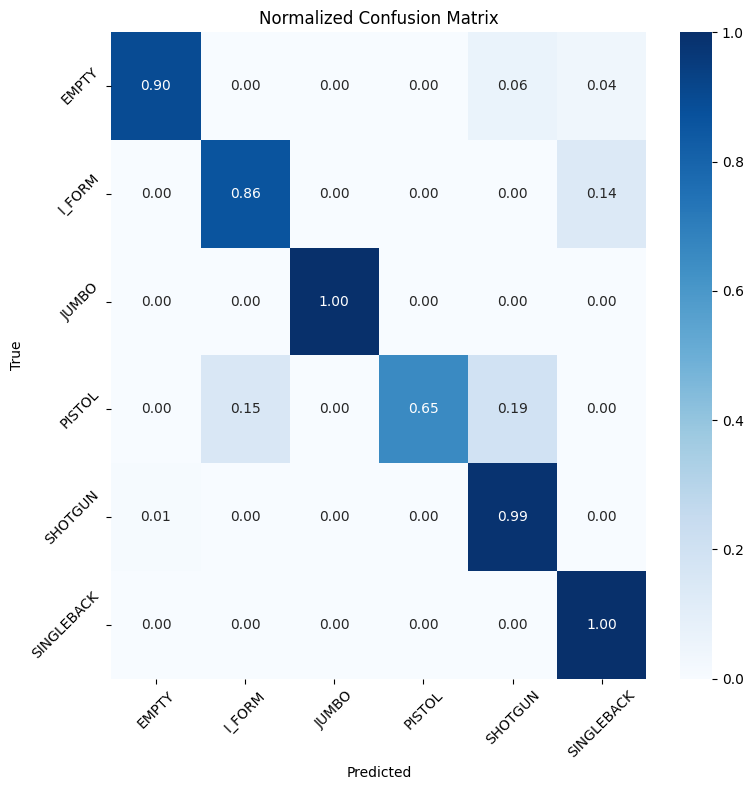

In [27]:
conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')
present_classes = sorted(list(set(np.unique(true_labels)) | set(np.unique(predicted_labels))))
present_labels = [formation_labels[i] for i in present_classes]

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=present_labels, yticklabels=present_labels)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [28]:
pip install jinja2 pdfkit


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Note: you may need to restart the kernel to use updated packages.


In [29]:
from IPython.display import display, HTML

In [30]:
games = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2025/games.csv')
plays = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2025/plays.csv')
players = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2025/players.csv')

print("Games dataset preview:")
display(games.head())
print("Plays dataset preview:")
display(plays.head())
print("Players dataset preview:")
display(players.head())

Games dataset preview:


,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,9/8/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,9/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,9/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,9/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,9/11/2022,13:00:00,CIN,PIT,20,23


Plays dataset preview:


,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,...,9,0.004634,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,1,10,CIN,DAL,CIN,8,...,4,0.002847,-0.002847,-0.240509,True,NaN,NaN,0,Quarters,Zone
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,...,6,0.000205,-0.000205,-0.218480,True,NaN,NaN,0,Quarters,Zone
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,...,4,-0.001308,0.001308,-0.427749,True,NaN,NaN,0,Quarters,Zone
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,2,8,BAL,TB,TB,27,...,-1,0.027141,-0.027141,-0.638912,False,MAN,READ OPTION,0,Cover-1,Man


Players dataset preview:


,nflId,height,weight,birthDate,collegeName,position,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan


In [31]:
# Calculating average scores for home and visitor teams
avg_home_score = games['homeFinalScore'].mean()
avg_visitor_score = games['visitorFinalScore'].mean()

# Basic statistics on scores
score_summary = games[['homeFinalScore', 'visitorFinalScore']].describe()

# Display top teams by total points scored at home
top_home_teams = games.groupby('homeTeamAbbr')['homeFinalScore'].sum().nlargest(5).reset_index()

In [32]:
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>NFL Data Analysis Report</title>
    <style>
        body {{ font-family: Arial, sans-serif; color: #ddd; background-color: #2b2b2b; }}
        h1, h2 {{ color: #5a9bd3; }}
        h1 {{ font-size: 2rem; }}
        h2 {{ font-size: 1.5rem; }}
        
        table {{ width: 60%; margin: 20px 0; border-collapse: collapse; }}
        th, td {{ padding: 10px 15px; border: 1px solid #444; font-size: 1rem; }}
        
        th {{
            background-color: #444; 
            color: #ffffff;
            font-weight: bold;
        }}
        
        td {{
            background-color: #333;
            color: #ddd;
        }}
        
        /* Alternating row colors for improved readability */
        tr:nth-child(even) td {{ background-color: #3a3a3a; }}
        
        /* Hover effect for table rows */
        tr:hover td {{ background-color: #555; color: #ffffff; }}
    </style>
</head>
<body>

<h1>NFL Data Analysis Report</h1>

<h2>Overall Statistics</h2>
<p>Average Home Final Score: {avg_home_score}</p>
<p>Average Visitor Final Score: {avg_visitor_score}</p>

<h2>Score Summary</h2>
{score_summary.to_html(index=True)}

<h2>Top 5 Home Teams by Total Points</h2>
{top_home_teams.to_html(index=False)}

</body>
</html>
"""

# Display HTML content in the notebook
from IPython.display import display, HTML
display(HTML(html_content))


In [33]:
output_html_path = "/kaggle/working/nfl_report.html"
with open(output_html_path, "w") as file:
    file.write(html_content)

print(f"Report saved to: {output_html_path}")

Report saved to: /kaggle/working/nfl_report.html


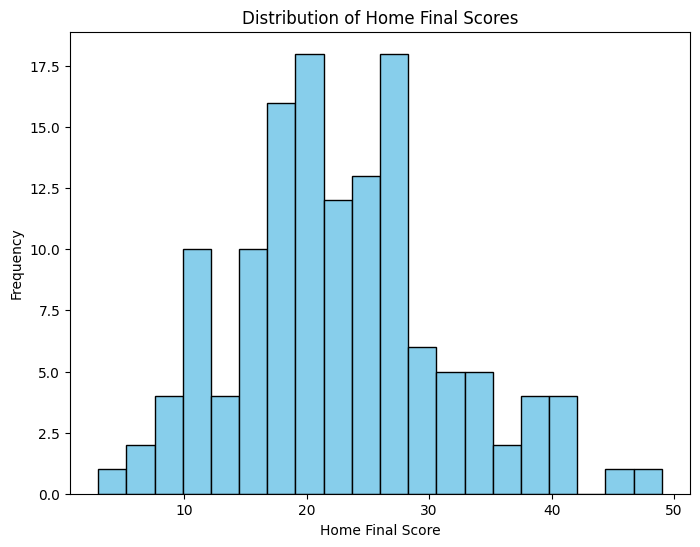

In [34]:
plt.figure(figsize=(8, 6))
plt.hist(games['homeFinalScore'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Home Final Scores")
plt.xlabel("Home Final Score")
plt.ylabel("Frequency")
plt.savefig("/kaggle/working/home_score_distribution.png")
plt.show()

html_content += """
<h2>Distribution of Home Final Scores</h2>
<img src="home_score_distribution.png" alt="Home Final Score Distribution">
"""


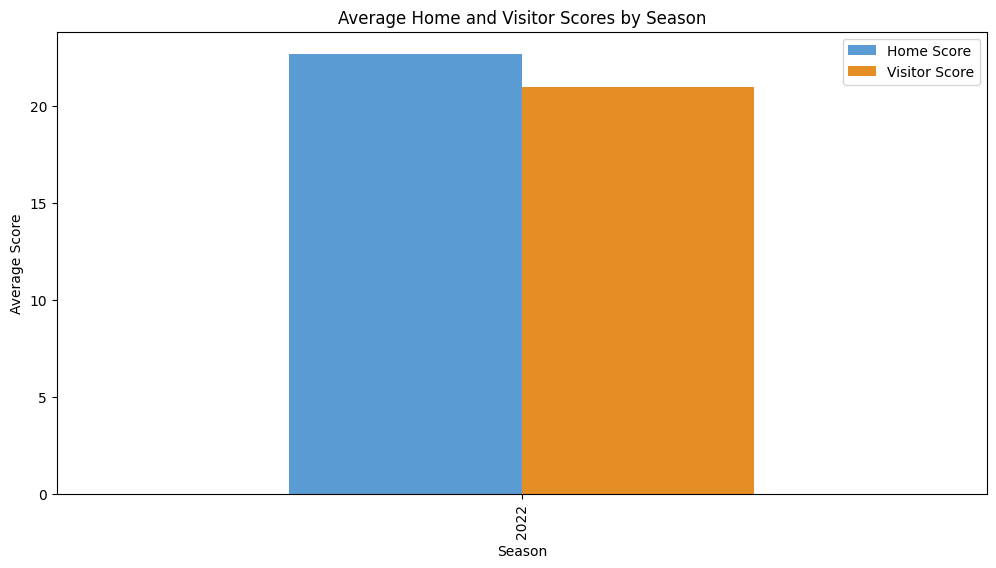

In [35]:
# Average home and visitor scores by season
season_performance = games.groupby('season').agg(
    AvgHomeScore=('homeFinalScore', 'mean'),
    AvgVisitorScore=('visitorFinalScore', 'mean')
).reset_index()

season_performance.plot(x='season', y=['AvgHomeScore', 'AvgVisitorScore'], kind='bar', figsize=(12, 6), color=['#5a9bd3', '#e58e26'])
plt.title("Average Home and Visitor Scores by Season")
plt.xlabel("Season")
plt.ylabel("Average Score")
plt.legend(["Home Score", "Visitor Score"])
plt.show()


/tmp/ipykernel_30/2148755624.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



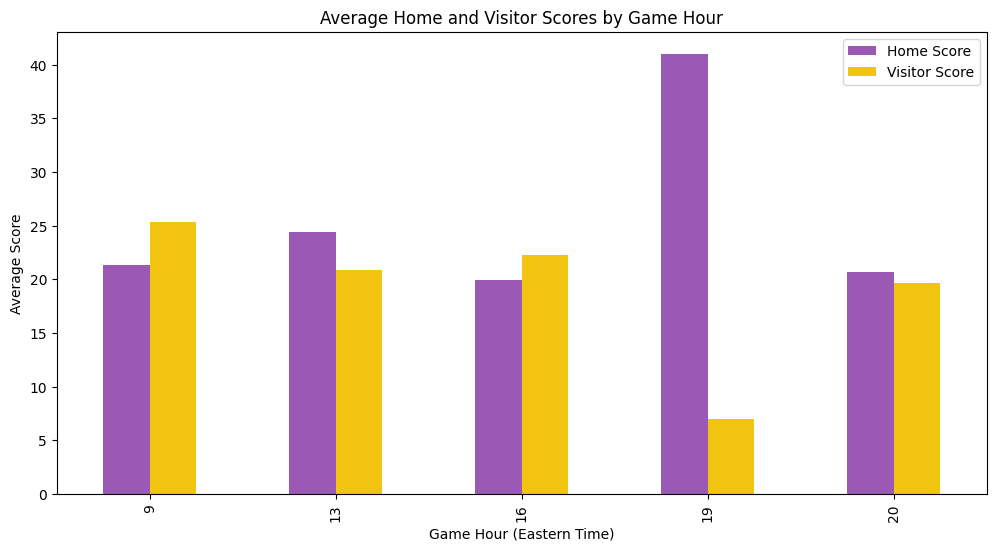

In [38]:
# Extract hour from gameTimeEastern and convert to integer
games['gameHour'] = pd.to_datetime(games['gameTimeEastern']).dt.hour

# Average scores by game hour
score_by_hour = games.groupby('gameHour').agg(
    AvgHomeScore=('homeFinalScore', 'mean'),
    AvgVisitorScore=('visitorFinalScore', 'mean')
).reset_index()

# Plotting scores by hour
score_by_hour.plot(x='gameHour', y=['AvgHomeScore', 'AvgVisitorScore'], kind='bar', figsize=(12, 6), color=['#9b59b6', '#f1c40f'])
plt.title("Average Home and Visitor Scores by Game Hour")
plt.xlabel("Game Hour (Eastern Time)")
plt.ylabel("Average Score")
plt.legend(["Home Score", "Visitor Score"])
plt.show()


In [39]:
import glob

tracking_files = glob.glob('/kaggle/input/nfl-big-data-bowl-2025/tracking_week_*.csv')
tracking_data = pd.concat([pd.read_csv(file) for file in tracking_files], ignore_index=True)

print("Combined tracking data shape:", tracking_data.shape)
print(tracking_data.head())

Combined tracking data shape: (59327373, 18)
       gameId  playId    nflId   displayName  frameId    frameType  \
0  2022102400      66  37087.0  Robert Quinn        1  BEFORE_SNAP   
1  2022102400      66  37087.0  Robert Quinn        2  BEFORE_SNAP   
2  2022102400      66  37087.0  Robert Quinn        3  BEFORE_SNAP   
3  2022102400      66  37087.0  Robert Quinn        4  BEFORE_SNAP   
4  2022102400      66  37087.0  Robert Quinn        5  BEFORE_SNAP   

                    time  jerseyNumber club playDirection      x      y     s  \
0  2022-10-25 00:16:40.6          94.0  CHI         right  28.63  25.37  1.29   
1  2022-10-25 00:16:40.7          94.0  CHI         right  28.63  25.50  1.38   
2  2022-10-25 00:16:40.8          94.0  CHI         right  28.63  25.64  1.45   
3  2022-10-25 00:16:40.9          94.0  CHI         right  28.63  25.78  1.46   
4    2022-10-25 00:16:41          94.0  CHI         right  28.64  25.93  1.46   

      a   dis       o   dir                 eve

In [40]:
tracking_data['time'] = pd.to_datetime(tracking_data['time'], errors='coerce')

# Sort by player and time to ensure correct order of calculation
tracking_data = tracking_data.sort_values(by=['nflId', 'time'])

# Calculate speed
tracking_data['speed'] = np.sqrt(tracking_data['x'].diff()**2 + tracking_data['y'].diff()**2) / tracking_data['time'].diff().dt.total_seconds()

# Calculate acceleration (change in speed over time)
tracking_data['acceleration'] = tracking_data['speed'].diff() / tracking_data['time'].diff().dt.total_seconds()

# Handling potential NaN values (e.g., initial rows where diff() has no previous value)
tracking_data['speed'].fillna(0, inplace=True)
tracking_data['acceleration'].fillna(0, inplace=True)

# Display the updated tracking data with speed and acceleration
print(tracking_data[['nflId', 'x', 'y', 'time', 'speed', 'acceleration']].head(10))

/tmp/ipykernel_30/3053016727.py:16: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_30/3053016727.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or d

            nflId      x      y                    time  speed  acceleration
45976011  25511.0  24.42  27.18 2022-09-12 00:36:35.500    0.0  0.000000e+00
45976012  25511.0  24.42  27.19 2022-09-12 00:36:35.600    0.1  0.000000e+00
45976013  25511.0  24.43  27.19 2022-09-12 00:36:35.700    0.1 -3.552714e-13
45976014  25511.0  24.43  27.18 2022-09-12 00:36:35.800    0.1  3.552714e-13
45976015  25511.0  24.43  27.18 2022-09-12 00:36:35.900    0.0 -1.000000e+00
45976017  25511.0  24.43  27.18 2022-09-12 00:36:36.100    0.0  0.000000e+00
45976018  25511.0  24.43  27.18 2022-09-12 00:36:36.200    0.0  0.000000e+00
45976019  25511.0  24.43  27.18 2022-09-12 00:36:36.300    0.0  0.000000e+00
45976020  25511.0  24.42  27.18 2022-09-12 00:36:36.400    0.1  1.000000e+00
45976021  25511.0  24.42  27.18 2022-09-12 00:36:36.500    0.0 -1.000000e+00


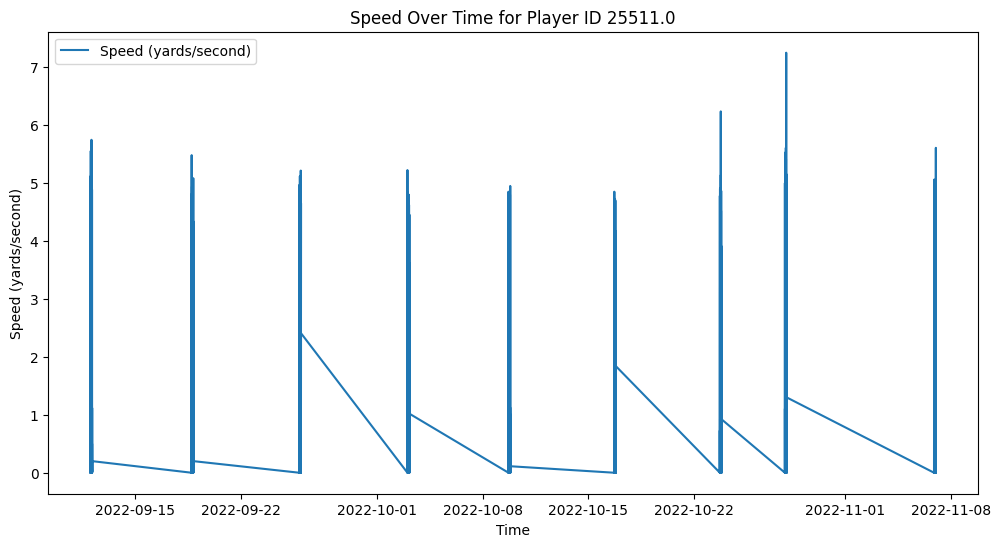

In [41]:
# Filter data for a specific player (replace with a specific nflId from the dataset)
sample_player_id = tracking_data['nflId'].iloc[0]  # or manually specify an ID, e.g., 2543542
player_data = tracking_data[tracking_data['nflId'] == sample_player_id]

# Plot speed over time for the selected player
plt.figure(figsize=(12, 6))
plt.plot(player_data['time'], player_data['speed'], label='Speed (yards/second)')
plt.title(f'Speed Over Time for Player ID {sample_player_id}')
plt.xlabel('Time')
plt.ylabel('Speed (yards/second)')
plt.legend()
plt.show()

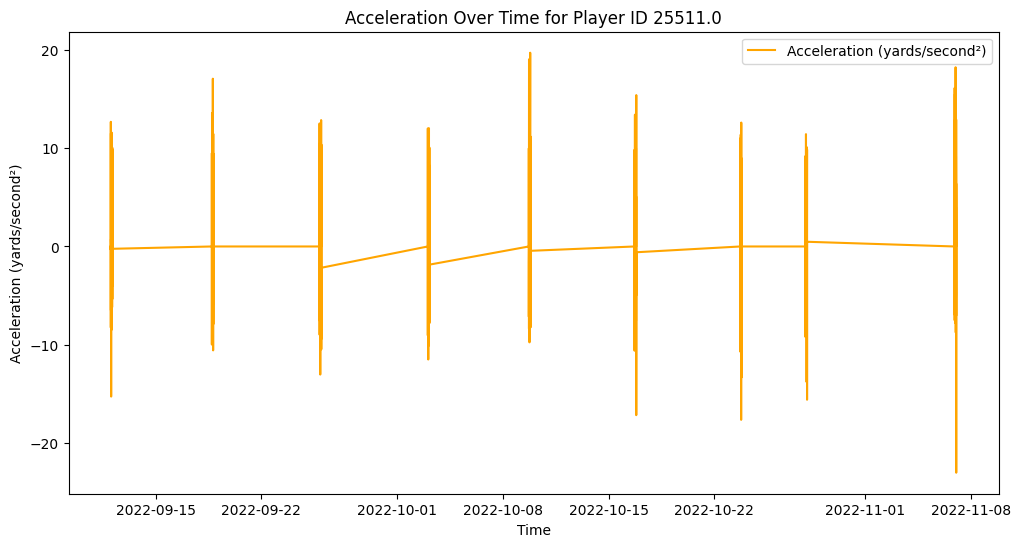

In [42]:
# Plot acceleration over time for the selected player
plt.figure(figsize=(12, 6))
plt.plot(player_data['time'], player_data['acceleration'], color='orange', label='Acceleration (yards/second²)')
plt.title(f'Acceleration Over Time for Player ID {sample_player_id}')
plt.xlabel('Time')
plt.ylabel('Acceleration (yards/second²)')
plt.legend()
plt.show()


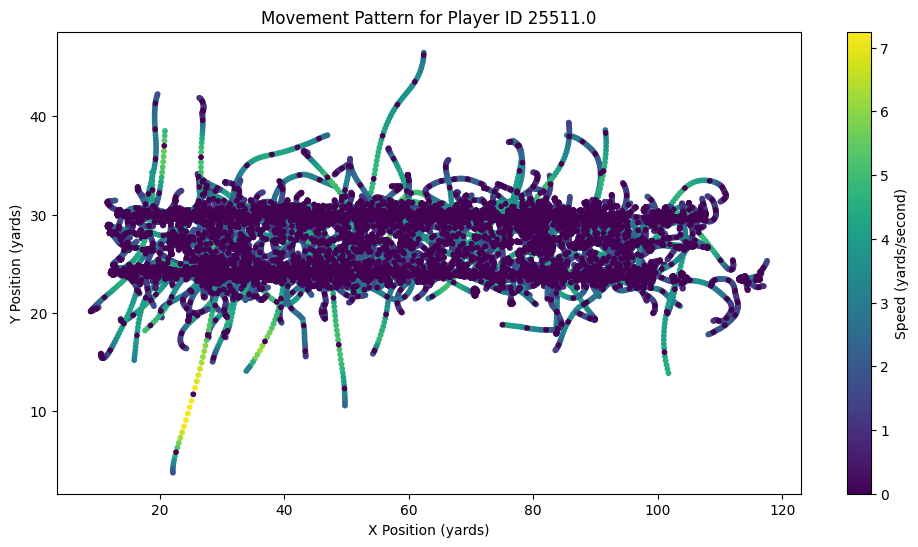

In [43]:
# Scatter plot of player movement (x, y positions)
plt.figure(figsize=(12, 6))
plt.scatter(player_data['x'], player_data['y'], c=player_data['speed'], cmap='viridis', s=10)
plt.colorbar(label='Speed (yards/second)')
plt.title(f'Movement Pattern for Player ID {sample_player_id}')
plt.xlabel('X Position (yards)')
plt.ylabel('Y Position (yards)')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



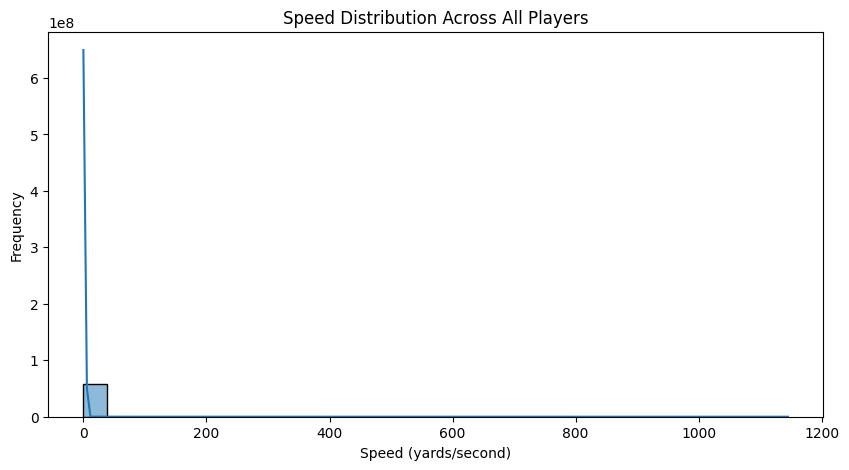

In [44]:
# Plot histogram of speeds across all players
plt.figure(figsize=(10, 5))
sns.histplot(tracking_data['speed'], bins=30, kde=True)
plt.title('Speed Distribution Across All Players')
plt.xlabel('Speed (yards/second)')
plt.ylabel('Frequency')
plt.show()


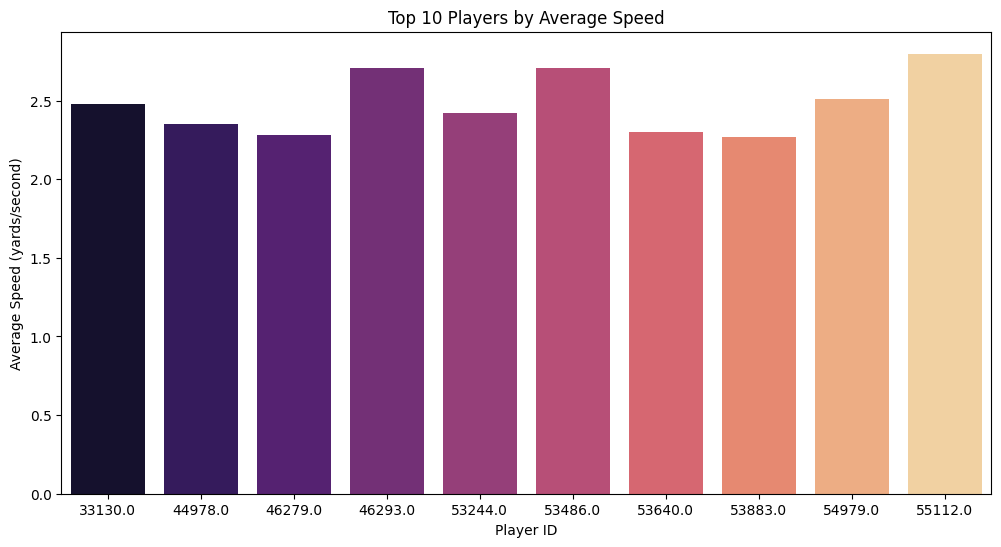

In [45]:
# Calculate average speed per player
average_speed_per_player = tracking_data.groupby('nflId')['speed'].mean().reset_index()

# Sort by average speed and select the top 10 fastest players
top_players = average_speed_per_player.nlargest(10, 'speed')

# Plot the top 10 players with the highest average speed
plt.figure(figsize=(12, 6))
sns.barplot(data=top_players, x='nflId', y='speed', palette='magma')
plt.title('Top 10 Players by Average Speed')
plt.xlabel('Player ID')
plt.ylabel('Average Speed (yards/second)')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



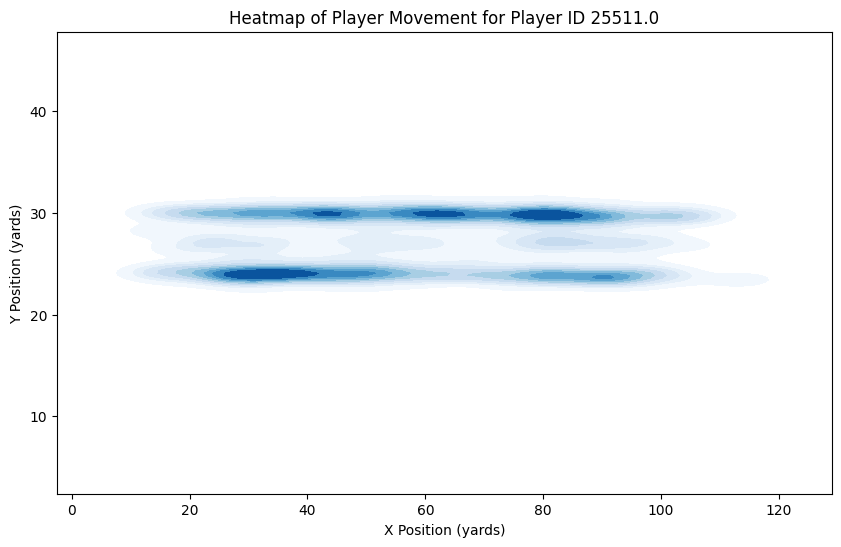

In [46]:
plt.figure(figsize=(10, 6))
sns.kdeplot(x=player_data['x'], y=player_data['y'], cmap="Blues", fill=True, thresh=0.05)
plt.title(f'Heatmap of Player Movement for Player ID {sample_player_id}')
plt.xlabel('X Position (yards)')
plt.ylabel('Y Position (yards)')
plt.show()


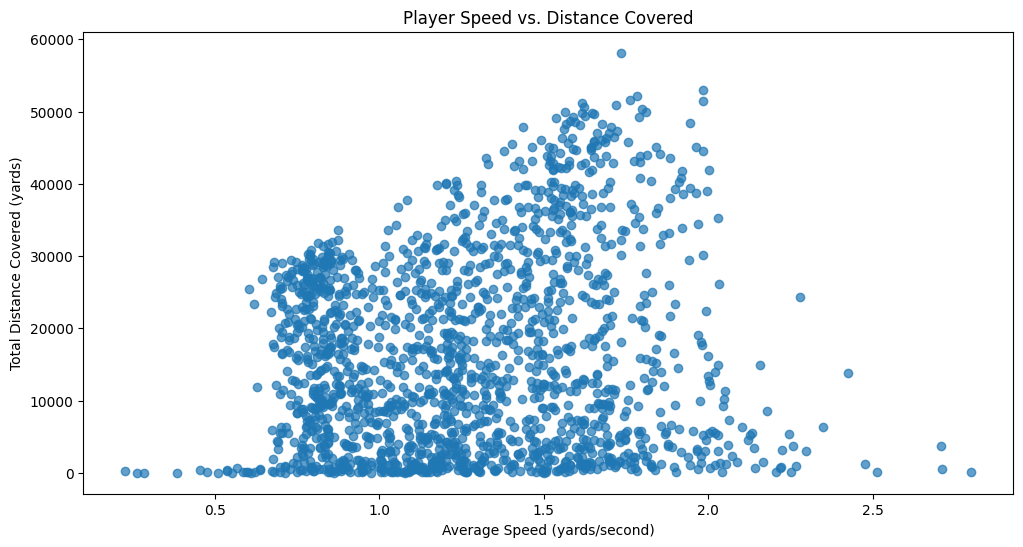

In [47]:
# Calculate distance covered per player
tracking_data['distance'] = np.sqrt(tracking_data['x'].diff()**2 + tracking_data['y'].diff()**2)
total_distance_per_player = tracking_data.groupby('nflId')['distance'].sum()
avg_speed_per_player = tracking_data.groupby('nflId')['speed'].mean()

# Plotting total distance vs. average speed
plt.figure(figsize=(12, 6))
plt.scatter(avg_speed_per_player, total_distance_per_player, alpha=0.7)
plt.title('Player Speed vs. Distance Covered')
plt.xlabel('Average Speed (yards/second)')
plt.ylabel('Total Distance Covered (yards)')
plt.show()


<Figure size 1000x600 with 0 Axes>

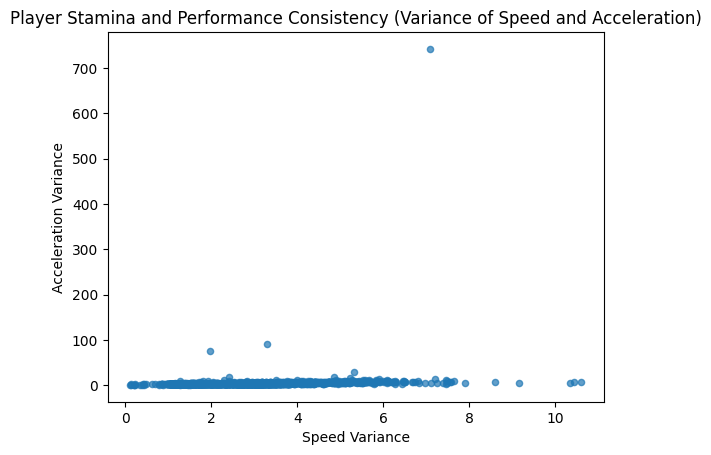

In [48]:
# Calculate variance in speed and acceleration per player
speed_variance = tracking_data.groupby('nflId')['speed'].var()
acceleration_variance = tracking_data.groupby('nflId')['acceleration'].var()

# Combine into a DataFrame for plotting
stamina_df = pd.DataFrame({'speed_variance': speed_variance, 'acceleration_variance': acceleration_variance})

plt.figure(figsize=(10, 6))
stamina_df.plot(kind='scatter', x='speed_variance', y='acceleration_variance', alpha=0.7)
plt.title('Player Stamina and Performance Consistency (Variance of Speed and Acceleration)')
plt.xlabel('Speed Variance')
plt.ylabel('Acceleration Variance')
plt.show()


In [49]:
print(tracking_data['club'].unique())


['TB' 'DAL' 'GB' 'IND' 'NYJ' 'BAL' 'KC' 'NE' 'LA' 'LAC' 'SF' 'PIT' 'PHI'
 'DEN' 'HOU' 'BUF' 'JAX' 'SEA' 'ARI' 'MIN' 'CHI' 'NO' 'NYG' 'TEN' 'DET'
 'MIA' 'LV' 'ATL' 'CIN' 'WAS' 'CLE' 'CAR' 'football']


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



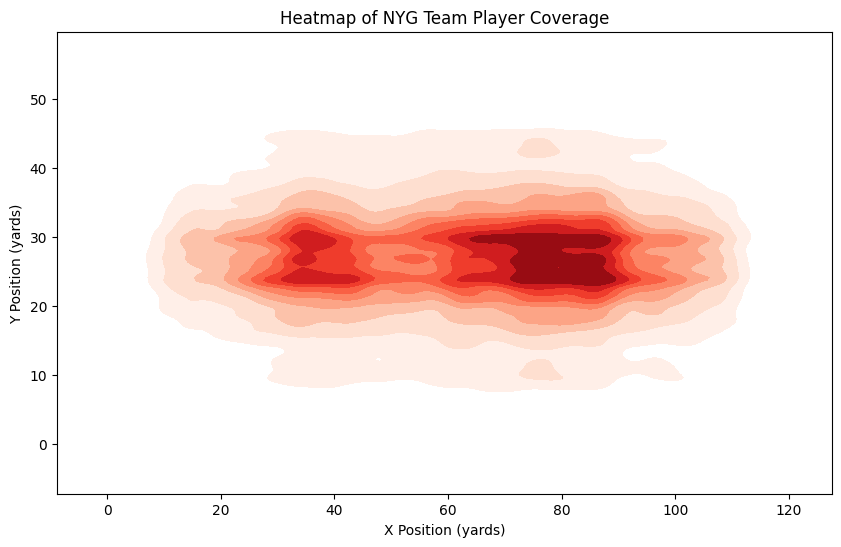

In [50]:
# Filter data for a specific team, e.g., 'DEN' for Denver
team_abbreviation = 'NYG'  # Replace with the team you want to visualize
team_data = tracking_data[tracking_data['club'] == team_abbreviation]

# Plotting the heatmap of player coverage for the selected team
plt.figure(figsize=(10, 6))
sns.kdeplot(x=team_data['x'], y=team_data['y'], cmap="Reds", fill=True, thresh=0.05)
plt.title(f'Heatmap of {team_abbreviation} Team Player Coverage')
plt.xlabel('X Position (yards)')
plt.ylabel('Y Position (yards)')
plt.show()
